## Library

In [1]:
! pip install pyts

     |████████████████████████████████| 2.5 MB 9.4 MB/s 


In [2]:
import numpy as np 
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
import os
import sys 


%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.image import RecurrencePlot
from pyts.image import MarkovTransitionField
from pyts.datasets import load_gunpoint
import pandas as pd

from keras.utils import np_utils

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

from sklearn.ensemble import RandomForestClassifier
import xgboost

import joblib

import matplotlib.pyplot as plt

## Определяем директории, загружаем датасет

In [110]:
# # PC
# DIR_weight = 'F:/Мой диск/Colab Notebooks/ROBO/My_Feature_from_NET/save_model_more0/'
# DIR_dataset = 'F:/Мой диск/Colab Notebooks/ROBO/My_Feature_from_NET/Data/all/'
# DIR_csv = 'F:/Мой диск/Colab Notebooks/ROBO/My_Feature_from_NET/Data/all/'

# Colab
from google.colab import drive
drive.mount('/content/drive')

DIR_weight  = '/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/save_model_more0/' # веса нейросети
DIR_RF  = '/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/save_model_2/' # сохраненная модель RandomForest
DIR_dataset = '/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/all/'  # исторические котировки, нужны для оценки финансового результата использования модели
DIR_csv = '/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/' # файлы со свежими котировками

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Загружаем файл с уже закаченными котировками наиболее ликвидных росакций
all = pd.read_csv(DIR_dataset + 'all_3009.csv', parse_dates=['Date'])

In [28]:
# Структура файла следующая:
all.head()

,Date,Open,High,Low,Close,Volume,Symbol
0,2011-11-17 10:00:00,79.70,80.20,79.25,80.10,1.967789e+09,SBER
1,2011-11-17 11:00:00,80.10,80.40,79.63,79.84,2.103682e+09,SBER
2,2011-11-17 12:00:00,79.84,79.91,79.03,79.56,3.646895e+09,SBER
3,2011-11-17 13:00:00,79.53,79.85,78.85,79.13,2.418619e+09,SBER
4,2011-11-17 14:00:00,79.13,79.25,78.00,78.81,3.812349e+09,SBER


In [23]:
# обьединяем файлы со свежими котировками в 1 файл

def in_one(parse_dates = ['Date'], dir = '/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/'):
  files = os.listdir(dir)
  if len(files) > 1:

    all_ = pd.DataFrame()
    for i in files:
        try:
            print(dir + i)
            stock = pd.read_csv(dir + i, parse_dates=parse_dates)
            stock['Symbol'] = i.split('.')[0]
            all_ = all_.append(stock)          
        except:
            continue
  else:
    all_ = pd.read_csv(dir + files[0], parse_dates=parse_dates)
# all_.columns   = ['Symbol', 'per', 'Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume', ]
# all_.sort_values(by = ['Symbol', 'Date', 'Time'], inplace = True)
  all_.reset_index(inplace=True, drop=True)  
  return all_
new_all = in_one(dir = DIR_csv)

/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/ALRS.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/AFKS.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/YNDX.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/AKRN.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/AFLT.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/IRAO.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/MGNT.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/MAGN.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/MTLR.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/MTSS.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/MOEX.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/NLMK.csv
/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/

In [48]:
# подгружаем к историческим новые котировки, убираем повторы, сортируем
# all = pd.concat([all, new_all])
# all.drop_duplicates(subset=['Date', 'Symbol'], inplace=True)
# all.sort_values(by = ['Symbol', 'Date'], inplace=True)
all.reset_index(inplace=True, drop=True)
all.shape

(781538, 18)

In [58]:
all.drop(columns=[i for i in list(range(10))], inplace=True)

## Создаем новые столбцы для датасета

### 10 Close

In [46]:
#  Каждому Close сопоставим 9 предыдущих Close 
long = 10

def n_sequant(data, long, close):
  dataset_np = np.array(data[close])
  for i in range(len(dataset_np)):
    if i == 0:
      np_array = np.array(long*[dataset_np[i]])
    elif i >= long - 1:
      np_array = np.row_stack([np_array, dataset_np[i - long + 1:i + 1]])
      pass
    else:
      np_array = np.row_stack([np_array, np.array(long*[dataset_np[i]])])
      
  return np_array

In [59]:
def use_n_sequant(data, func, long, close):
  df_all = pd.DataFrame()
  for sum in data['Symbol'].unique():
    df = data[data['Symbol'] == sum]
    df_func = pd.DataFrame(func(df, long, close))
    df_all = pd.concat([df_all, df_func])
    df_all.reset_index(inplace=True, drop=True)
  all = pd.concat([data, df_all], axis = 1)
  if np.mean(all[long - 1] - all['Close']) == 0:
    print('OK')
  else:
    print('Error')

  return all, df_all

all, seq = use_n_sequant(all, n_sequant, 10, 'Close')

OK


In [62]:
# Тут видим что Close и 9 совпадают, это Close вчера, 7 это Close позавчера итд
all.tail(10)

,Date,Open,High,Low,Close,Volume,Symbol,0,1,2,3,4,5,6,7,8,9
781528,2020-09-28 14:00:00,72.10,72.18,72.00,72.14,36339834.5,ALRS,71.61,71.79,71.90,71.94,71.98,71.99,71.80,72.08,72.09,72.14
781529,2020-09-28 15:00:00,72.14,72.24,71.68,71.91,165351263.9,ALRS,71.79,71.90,71.94,71.98,71.99,71.80,72.08,72.09,72.14,71.91
781530,2020-09-28 16:00:00,71.92,72.10,71.81,71.97,40341096.3,ALRS,71.90,71.94,71.98,71.99,71.80,72.08,72.09,72.14,71.91,71.97
781531,2020-09-28 17:00:00,71.97,72.02,71.84,71.97,54116370.0,ALRS,71.94,71.98,71.99,71.80,72.08,72.09,72.14,71.91,71.97,71.97
781532,2020-09-28 18:00:00,71.97,72.27,71.96,72.10,133463841.2,ALRS,71.98,71.99,71.80,72.08,72.09,72.14,71.91,71.97,71.97,72.10
781533,2020-09-28 19:00:00,72.10,72.36,72.10,72.30,6236445.4,ALRS,71.99,71.80,72.08,72.09,72.14,71.91,71.97,71.97,72.10,72.30
781534,2020-09-28 20:00:00,72.30,72.33,72.20,72.29,3428184.8,ALRS,71.80,72.08,72.09,72.14,71.91,71.97,71.97,72.10,72.30,72.29
781535,2020-09-28 21:00:00,72.29,72.49,72.25,72.45,9442597.2,ALRS,72.08,72.09,72.14,71.91,71.97,71.97,72.10,72.30,72.29,72.45
781536,2020-09-28 22:00:00,72.40,72.69,72.40,72.58,12247896.3,ALRS,72.09,72.14,71.91,71.97,71.97,72.10,72.30,72.29,72.45,72.58
781537,2020-09-28 23:00:00,72.60,72.76,72.57,72.64,6227402.2,ALRS,72.14,71.91,71.97,71.97,72.10,72.30,72.29,72.45,72.58,72.64


### Пронумеруем котировки внутри дня. Long  - начиная с первого часового бара (первый ряд дня это 1, второй ряд дня это 2 итд), Short - в обратном порядке. Теперь мы знаем что long=1 это первый Close дня, а Short = 1 это последний Close дня. Кроме того найдем Cl_firs_tomor - цена акции в 11 часов следующего дня 


In [64]:
def lfl(df_f_all):
  data_np = np.array(df_f_all['Date'].dt.date)
  close_np = np.array(df_f_all['Close'])
  Cl_firs_tomor = np.zeros(shape=data_np.size)

  # #Short
  k1 = []

  for i in range(data_np.size-1, -1, -1):
    # print(i)
    if i == data_np.size - 1:
      k = 1

    elif data_np[i] == data_np[i+1]:

      k += 1

    else:

      k = 1
    k1.append(k)

  df_f_all['Short'] = k1[::-1]  

  # Long
  k1 = []

  for i in range(data_np.size):
    if i == 0:
      k = 1

    elif data_np[i] == data_np[i-1]:

      k += 1

    else:

      k = 1
    k1.append(k)

  df_f_all['Long'] = k1

  # Clo_tomor

  for i in range(data_np.size-1, -1, -1):

    if i == data_np.size - 1:
      Cl_firs_tomor[i]  =  close_np[i]

    elif data_np[i] == data_np[i+1]:
      Cl_firs_tomor[i]  =  Cl_firs_tomor[i+1]

    else:
      Cl_firs_tomor[i]  = close_np[i+1]
  
  df_f_all['Cl_firs_tomor'] = Cl_firs_tomor


In [68]:
# Ставим max_hour = 18 и min_hour =10 потому что сейчас существует вечерняя сессия, которая нам не интересна
def use_lfl(df_f_all, max_hour = 18, min_hour = 10):
  df_all = pd.DataFrame()
  for i in df_f_all['Symbol'].unique():
    df = df_f_all[df_f_all['Symbol'] == i]
    df = df[(df['Date'].dt.hour <= max_hour)&(df['Date'].dt.hour >= min_hour)]
    lfl(df)
    df_all = pd.concat([df_all, df])
    df_all.reset_index(inplace=True, drop = True)
  return df_all

all = use_lfl(all)

In [89]:
# время
all['Date'] = pd.to_datetime(all['Date'])
all['Hour'] = all['Date'].dt.hour
all['Year'] = all['Date'].dt.year

# создаем таргет - Proft_comb_label, показывает относительно текущего Close выше или ниже Close через несколько часов

# изменение цены к завтрашнему утру
all['Proft1000']  = (all['Cl_firs_tomor']/all['Close'].shift(0)-1)*100
all['Proft1000'] = np.where(all['Proft1000'] > 20, 20, np.where(all['Proft1000'] < -20, -20, all['Proft1000']))
all['Proft1000_label'] = np.where(all['Proft1000']>0, 1, 0)
# изменение цены через 6 часов
all['Proft_6_hour'] = np.where(all['Symbol'].shift(-6) == all['Symbol'].shift(0), (all['Close'].shift(-6)/all['Close'].shift(0) - 1)*100, None)
all['Proft_6_hour_label'] = np.where(all['Proft_6_hour'] > 0, 1, 0)
# Комбинированный label
all['Proft_comb_label'] = np.where(all['Hour'] < 15, all['Proft1000_label'], all['Proft_6_hour_label'])

# время
all['Date'] = pd.to_datetime(all['Date'])
all['Hour'] = all['Date'].dt.hour

# изменение за час
all['profit_hour'] = (all['Close'].shift(-1)/all['Close'] - 1) * 100
all['profit_hour'] = np.where(all['profit_hour'] > 20, 20, np.where(all['profit_hour'] < -20, -20, all['profit_hour']))
all['profit_hour_label'] = np.where(all['profit_hour'] > 0, 1, 0)

all.head(10)

,Date,Open,High,Low,Close,Volume,Symbol,0,1,2,3,4,5,6,7,8,9,Short,Long,Cl_firs_tomor,Proft1000,Proft1000_label,Hour,Proft_6_hour,Proft_6_hour_label,Proft_comb_label,profit_hour,profit_hour_label,min10_est,min10_est_label,Year
0,2011-11-17 10:00:00,79.70,80.20,79.25,80.10,1.967789e+09,SBER,80.10,80.10,80.10,80.10,80.10,80.10,80.10,80.10,80.10,80.10,9,1,78.90,-1.498127,0,10,-0.31211,0,0,-0.324594,0,0.073231,0,2011
1,2011-11-17 11:00:00,80.10,80.40,79.63,79.84,2.103682e+09,SBER,79.84,79.84,79.84,79.84,79.84,79.84,79.84,79.84,79.84,79.84,8,2,78.90,-1.177355,0,11,0.826653,1,0,-0.350701,0,0.073231,0,2011
2,2011-11-17 12:00:00,79.84,79.91,79.03,79.56,3.646895e+09,SBER,79.56,79.56,79.56,79.56,79.56,79.56,79.56,79.56,79.56,79.56,7,3,78.90,-0.829563,0,12,1.11865,1,0,-0.540473,0,0.073231,0,2011
3,2011-11-17 13:00:00,79.53,79.85,78.85,79.13,2.418619e+09,SBER,79.13,79.13,79.13,79.13,79.13,79.13,79.13,79.13,79.13,79.13,6,4,78.90,-0.290661,0,13,-0.290661,0,0,-0.404398,0,0.073231,0,2011
4,2011-11-17 14:00:00,79.13,79.25,78.00,78.81,3.812349e+09,SBER,78.81,78.81,78.81,78.81,78.81,78.81,78.81,78.81,78.81,78.81,5,5,78.90,0.114199,1,14,0.735947,1,1,-0.203020,0,0.073231,0,2011
5,2011-11-17 15:00:00,78.79,79.15,78.40,78.65,2.254422e+09,SBER,78.65,78.65,78.65,78.65,78.65,78.65,78.65,78.65,78.65,78.65,4,6,78.90,0.317864,1,15,0.534011,1,1,1.525747,1,0.073231,0,2011
6,2011-11-17 16:00:00,78.65,79.94,77.65,79.85,5.775682e+09,SBER,79.85,79.85,79.85,79.85,79.85,79.85,79.85,79.85,79.85,79.85,3,7,78.90,-1.189731,0,16,0.0500939,1,1,0.814026,1,0.073231,0,2011
7,2011-11-17 17:00:00,79.87,81.24,79.23,80.50,6.874480e+09,SBER,80.50,80.50,80.50,80.50,80.50,80.50,80.50,80.50,80.50,80.50,2,8,78.90,-1.987578,0,17,-1.13043,0,0,-0.062112,0,0.073231,0,2011
8,2011-11-17 18:00:00,80.50,81.63,80.26,80.45,4.533873e+09,SBER,80.45,80.45,80.45,80.45,80.45,80.45,80.45,80.45,80.45,80.45,1,9,78.90,-1.926663,0,18,-0.522063,0,0,-1.926663,0,0.073231,0,2011
9,2011-11-18 10:00:00,78.95,79.41,78.33,78.90,3.516237e+09,SBER,80.10,79.84,79.56,79.13,78.81,78.65,79.85,80.50,80.45,78.90,9,1,79.15,0.316857,1,10,1.7744,1,1,0.621039,1,0.000379,0,2011


## Загружаем нейросеть и веса обученной нейросети

Я обучил нейросеть которая из 10 последних Close и Long считает min10_est, которая в последующем будет в качестве признака для прогнозирования. min10_est это что то вроде средней цены акции за последние 10 часов. Нейросеть тут в качестве калькулятора   

In [75]:
# приводим данные к одному масштабу

scaler = MinMaxScaler((0.1,0.9))
def use_scaler(data, func, columns):
  df_all = pd.DataFrame()
  for sum in data['Symbol'].unique():
    df = data[data['Symbol'] == sum]
    
    df_func = pd.DataFrame(scaler.fit_transform(df[columns].T)).T
    df_all = pd.concat([df_all, df_func])

    df_all.reset_index(inplace=True, drop=True)
  if len(all) == len(df_all):
    print('Ok')
    df_all.columns = columns
    return df_all

minmax_scale = use_scaler(all, scaler, [(i) for i in range(10)])
minmax_scale['Long'] = scaler.fit_transform(np.array(all['Long']).reshape(-1, 1))
minmax_scale


Ok


,0,1,2,3,4,5,6,7,8,9,Long
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1
1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.2
2,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.3
3,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.4
4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.5
...,...,...,...,...,...,...,...,...,...,...,...
729629,0.100000,0.371698,0.537736,0.598113,0.658491,0.673585,0.386792,0.809434,0.824528,0.900000,0.5
729630,0.100000,0.351429,0.442857,0.534286,0.557143,0.122857,0.762857,0.785714,0.900000,0.374286,0.6
729631,0.335294,0.429412,0.523529,0.547059,0.100000,0.758824,0.782353,0.900000,0.358824,0.500000,0.7
729632,0.429412,0.523529,0.547059,0.100000,0.758824,0.782353,0.900000,0.358824,0.500000,0.500000,0.8


In [76]:
# Делаем картинку с которой будет работать наша сверточная нейросеть

def get_gramian_input(X, n):
  gasf = GramianAngularField(image_size=int(n), method='summation')
  X_gasf = gasf.fit_transform(X)
  gadf = GramianAngularField(image_size=int(n), method='difference')
  X_gadf = gadf.fit_transform(X)

  xx  = np.array([X_gadf.T, X_gasf.T]).T
  print(xx.shape)
  return xx

X = get_gramian_input(minmax_scale, 11)

(729634, 11, 11, 2)


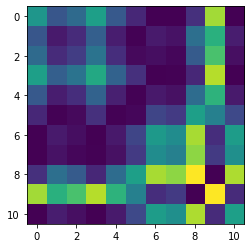

In [86]:
# Можно посомтреть как выглядит картинка
# plt.imshow(X[100,:,:,1])

In [77]:
# Загружаем модель с параметрами
params = {'batch_size': 80, 
          'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 
                                               'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 
                                               'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 
                                               'kernel_regularizer_2': 0.0, 'layers': 'two'}, 
          'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
          'epochs': 3000, 
          'lr': 0.001, 
          'optimizer': 'adam'}
          
def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    
    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],  #32
                           params["conv2d_layers"]["conv2d_kernel_size_1"], #3
                           strides=params["conv2d_layers"]["conv2d_strides_1"], #1
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]), 
                           padding='same',activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(11,
                                        11, 2))
    model.add(conv2d_layer1)
    if params["conv2d_layers"]['conv2d_mp_1'] > 1:
        model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_1']))
        
    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))
    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"], #64
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='same',activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)
        
        if params["conv2d_layers"]['conv2d_mp_2'] > 1:
            model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_2']))
        
        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))
    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu', 
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(2, activation='softmax'))
    
    return model

model_save = create_model_cnn(params)

Training with params {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}


In [80]:
# Загрузка весов из папки с весами
path_weight = DIR_weight
# model.save(path_weight)
model_save.load_weights(path_weight)

In [81]:
%%time
# Считаем с помощью нейросети min10_est
min10_est = model_save.predict(X)

CPU times: user 3min, sys: 7.12 s, total: 3min 7s
Wall time: 2min 23s


In [82]:
# Добавляем min10_est в датасет
all['min10_est'] = min10_est[:,1]
all['min10_est_label'] = np.where(all['min10_est']>0.5,1,0)

In [87]:
all

,Date,Open,High,Low,Close,Volume,Symbol,0,1,2,3,4,5,6,7,8,9,Short,Long,Cl_firs_tomor,Proft1000,Proft1000_label,Hour,Proft_6_hour,Proft_6_hour_label,Proft_comb_label,profit_hour,profit_hour_label,min10_est,min10_est_label
0,2011-11-17 10:00:00,79.70,80.20,79.25,80.10,1.967789e+09,SBER,80.10,80.10,80.10,80.10,80.10,80.10,80.10,80.10,80.10,80.10,9,1,78.9,-1.498127,0,10,-0.31211,0,0,-0.324594,0,0.073231,0
1,2011-11-17 11:00:00,80.10,80.40,79.63,79.84,2.103682e+09,SBER,79.84,79.84,79.84,79.84,79.84,79.84,79.84,79.84,79.84,79.84,8,2,78.9,-1.177355,0,11,0.826653,1,0,-0.350701,0,0.073231,0
2,2011-11-17 12:00:00,79.84,79.91,79.03,79.56,3.646895e+09,SBER,79.56,79.56,79.56,79.56,79.56,79.56,79.56,79.56,79.56,79.56,7,3,78.9,-0.829563,0,12,1.11865,1,0,-0.540473,0,0.073231,0
3,2011-11-17 13:00:00,79.53,79.85,78.85,79.13,2.418619e+09,SBER,79.13,79.13,79.13,79.13,79.13,79.13,79.13,79.13,79.13,79.13,6,4,78.9,-0.290661,0,13,-0.290661,0,0,-0.404398,0,0.073231,0
4,2011-11-17 14:00:00,79.13,79.25,78.00,78.81,3.812349e+09,SBER,78.81,78.81,78.81,78.81,78.81,78.81,78.81,78.81,78.81,78.81,5,5,78.9,0.114199,1,14,0.735947,1,1,-0.203020,0,0.073231,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729629,2020-09-28 14:00:00,72.10,72.18,72.00,72.14,3.633983e+07,ALRS,71.61,71.79,71.90,71.94,71.98,71.99,71.80,72.08,72.09,72.14,5,5,72.1,-0.055448,0,14,None,0,0,-0.318825,0,0.224642,0
729630,2020-09-28 15:00:00,72.14,72.24,71.68,71.91,1.653513e+08,ALRS,71.79,71.90,71.94,71.98,71.99,71.80,72.08,72.09,72.14,71.91,4,6,72.1,0.264219,1,15,None,0,0,0.083438,1,0.000878,0
729631,2020-09-28 16:00:00,71.92,72.10,71.81,71.97,4.034110e+07,ALRS,71.90,71.94,71.98,71.99,71.80,72.08,72.09,72.14,71.91,71.97,3,7,72.1,0.180631,1,16,None,0,0,0.000000,0,0.000376,0
729632,2020-09-28 17:00:00,71.97,72.02,71.84,71.97,5.411637e+07,ALRS,71.94,71.98,71.99,71.80,72.08,72.09,72.14,71.91,71.97,71.97,2,8,72.1,0.180631,1,17,None,0,0,0.180631,1,0.037398,0


In [113]:
name

'min10_est__Hour__Long__Short__Proft_comb_label'

In [117]:
# загружаем обученную модель RandomForest 

# load
rfc_save = joblib.load(DIR_RF + 'min10_est__Hour__Long__Short__Proft_comb_label.joblib')
rfc_save

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [130]:
X_test

,min10_est,Hour,Long,Short
18421,0.137279,10,1,9
18422,0.224687,11,2,8
18423,0.055967,12,3,7
18424,0.113857,13,4,6
18425,0.000003,14,5,5
...,...,...,...,...
729629,0.224642,14,5,5
729630,0.000878,15,6,4
729631,0.000376,16,7,3
729632,0.037398,17,8,2


In [133]:
# делаем прогноз
for_forecast = all[['min10_est', 'Hour', 'Long', 'Short']]
rfc_save.predict_proba(X_test)

array([[0.51249458, 0.48750542],
       [0.50284938, 0.49715062],
       [0.4956482 , 0.5043518 ],
       ...,
       [0.49806706, 0.50193294],
       [0.49886335, 0.50113665],
       [0.51105411, 0.48894589]])

In [ ]:
# Где первый столбец уверенность в росте, второй уверенность в падении. 

# Блок для обчения RandomForest и оценки финансового результат и обучения. 

## Приступаем к прогнозированию. Для этого обучим нашу модель (RandomForest) на следующих признаках: 'min10_est', 'Hour', 'Long', 'Short'. Обучаем и паралельно делаем прогноз, чтобы оценить финансовый результат от использования наших прогнозов по слудующей схеме: 1. Обучаем на данных за 2011 год и обученную модель используем для прогноза 2012 года. 2. Обучаем на данных за 2011+2012 годы и используем обученную модель для прогшноза 2013 года. 3  Обучаем на данных за 2011+2012+2013 годы и используем обученную модель для прогноза 2014 года. итд

In [90]:
data = all.copy()
feature = ['min10_est'] + ['Hour', 'Long', 'Short']
n_ = 2

Target_list = ['Proft_comb_label']
column = 'Year'
feat_importances = pd.DataFrame()
matrix_year   = pd.DataFrame()
   
for Target in Target_list:
        for itera_1 in [100]:
            for itera in [5]:
                for year in [2012,2013,2014,2015,2016,2017,2018,2019,2020]:
                  

                    X_all = data[feature] 
                    y_all = data[Target_list]    
                    X_train = X_all[(data[column] <  year)&(data[column] >= 2006)]
                    X_test  = X_all[data[column]  == year]
                    y_train = y_all[(data[column] <  year)&(data[column] >= 2006)]
                    y_test  = y_all[data[column]  == year]


                    rfc = RandomForestClassifier(n_estimators=itera_1, max_depth = itera, random_state=1, n_jobs = -1)
                    rfc.fit(X_train, y_train.values.ravel())

                    predictions_X_test      = rfc.predict_proba(X_test)
                    predict = predictions_X_test[:, 1]

                    matrix_2018 = data[data[column]  == year]
                    matrix_2018['2proba'] = predict
                    matrix_2018 = matrix_2018.assign(
                                                      Target  = str(Target),
                                                      itera_1 = str(itera_1),
                                                      itera   = str(itera),
                                                    )
                    print(year, matrix_year.shape)
                    matrix_year   = matrix_year.append(matrix_2018, ignore_index=True)
                    


matrix_year['proba2_range'] = \
                np.where(matrix_year['2proba']>0.55, 0.55,         
                np.where(matrix_year['2proba']>0.54, 0.54, 
                np.where(matrix_year['2proba']>0.53, 0.53,
                np.where(matrix_year['2proba']>0.52, 0.52, 
                np.where(matrix_year['2proba']>0.51, 0.51, 
                np.where(matrix_year['2proba']>0.50, 0.50, 
                np.where(matrix_year['2proba']>0.49, 0.49,
                np.where(matrix_year['2proba']>0.48, 0.48, 
                np.where(matrix_year['2proba']>0.47, 0.47,
                np.where(matrix_year['2proba']>0.46, 0.46, 
                np.where(matrix_year['2proba']>0.45, 0.45, 
                np.where(matrix_year['2proba']>0.44, 0.44,                        
                         0.43)))))))))))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2012 (0, 0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013 (74820, 35)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2014 (151827, 35)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2015 (232826, 35)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016 (317405, 35)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2017 (403216, 35)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018 (488837, 35)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019 (575019, 35)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2020 (659249, 35)


#### Save/Load RF

In [ ]:
# Схраняем веса RandomForest обученной на всех доступных данных.

# name = feature[0] + '__' + feature[1] + '__' + feature[2] + '__' + feature[3] + '__' + Target_list[0]

# save
# joblib.dump(rfc, DIR + 'save_model_2/' + name + ".joblib")

# load
# rfc = joblib.load(DIR + 'save_model_2/' + name + ".joblib")

## Смотрим на финансовый результат если следовать прогнозам

In [93]:
df_f_all = matrix_year.copy()
# threshold_in = 0.53
# threshold_out = 0.50


def mark(df_f_all, threshold_in = 0.52, threshold_out = 0.50, stop = False):
  hour_np = np.array(df_f_all['Date'].dt.hour)
  close_np = np.array(df_f_all['Close'])
  proba2_range_np = np.array(df_f_all['proba2_range'])
  pr1000_np = np.array(df_f_all['Proft1000'])
  signal = np.zeros(shape=len(df_f_all))
  close_hour = np.zeros(shape=len(df_f_all))
  close_hour_1 = np.zeros(shape=len(df_f_all))
  min_enter = np.zeros(shape=len(df_f_all))
  pr1000_enter = np.zeros(shape=len(df_f_all))
  profit_hour_np = np.zeros(shape=len(df_f_all))
  profit_hour_np_1 = np.zeros(shape=len(df_f_all))
  hold = np.zeros(shape=len(df_f_all))
  hold_1 = np.zeros(shape=len(df_f_all))


  for i in range(close_np.size):
    # print(proba2_range_np[i], i)
    # print(10*('ddddd'))
    if i == 0:
      # print(proba2_range_np[i])
      signal[i] = 0
    elif proba2_range_np[i] > threshold_in and (signal[i-1] == 0 or signal[i-1] == 3):
      # print(proba2_range_np[i])
      signal[i] = 1
      hold[i] = 1
    elif stop and hour_np[i] == 10 and (signal[i-1] == 2 or signal[i-1] == 1):      
      signal[i] = 3
      hold[i] = hold[i-1]
    elif proba2_range_np[i] > threshold_out and (signal[i-1] == 2 or signal[i-1] == 1):
      signal[i] = 2
      hold[i] = 1 + hold[i-1]      
    elif (proba2_range_np[i] <= threshold_out and (signal[i-1] == 2 or signal[i-1] == 1)):
      signal[i] = 3
      hold[i] = hold[i-1]
    elif proba2_range_np[i] <= threshold_in and (signal[i-1] == 0 or signal[i-1] == 3):
      # print(proba2_range_np[i])
      signal[i] = 0
      hold[i] = 0

  df_f_all['signal'] = signal
  df_f_all['hold'] = hold

  for i in range(close_np.size):
    # print(proba2_range_np[i], i)
    # print(10*('ddddd'))
    if i == 0 or signal[i] == 0:
      close_hour[i] = None
      pr1000_enter[i] = None
      profit_hour_np[i] = (close_np[i]/close_hour[i] - 1)*100
         
    elif signal[i] == 1:
      close_hour[i] = close_np[i]
      pr1000_enter[i]   = pr1000_np[i]
      profit_hour_np[i] = None
    else:
      close_hour[i] = close_hour[i-1]
      pr1000_enter[i]   = pr1000_enter[i-1]
      profit_hour_np[i] = (close_np[i]/close_hour[i] - 1)*100

    # for i in range(close_np.size-1, -1, -1):
    #   if signal[i] == 3 or i == close_np.size-1:
    #     close_hour_1[i] = close_np[i]
    #     profit_hour_np_1[i] = None
    #   else:
    #     close_hour_1[i] = close_hour_1[i+1]
    #     profit_hour_np_1[i] = (close_hour_1[i]/close_np[i] - 1)*100

  close_np_1 = close_np[::-1]
  signal_1 = signal[::-1]
  for i in range(close_np.size):
    if signal_1[i] == 3 or i == 0:
      close_hour_1[i] = close_np_1[i]
      profit_hour_np_1[i] = None
      hold_1[i] = 0
    else:
      close_hour_1[i] = close_hour_1[i-1]
      profit_hour_np_1[i] = (close_hour_1[i]/close_np_1[i] - 1)*100
      hold_1[i] = hold_1[i-1] + 1


  df_f_all['close_hour'] = close_hour
  df_f_all['profit_hour_np'] = profit_hour_np
  df_f_all['profit_hour_np'] = np.where(df_f_all['profit_hour_np'] > 20, 20, np.where(df_f_all['profit_hour_np'] < -20, -20, df_f_all['profit_hour_np']))
  df_f_all['min_enter'] = min_enter
  df_f_all['pr1000_enter'] = pr1000_enter

  
  df_f_all['profit_hour_np_1'] = profit_hour_np_1[::-1]
  df_f_all['profit_hour_np_1'] = np.where(df_f_all['profit_hour_np_1'] > 20, 20, np.where(df_f_all['profit_hour_np_1'] < -20, -20, df_f_all['profit_hour_np_1']))
  df_f_all['close_hour_1'] = close_hour_1[::-1]
  df_f_all['hold_1'] = hold_1[::-1]

  return df_f_all

df_f_all = mark(df_f_all, threshold_in = 0.52, threshold_out = 0.44, stop = True)

In [ ]:
# def use_mark(func, data, threshold_in = 0.53, threshold_out = 0.45, stop = True):
#   df_all = pd.DataFrame()
#   for sum in data['Symbol'].unique():
#     df = data[data['Symbol'] == sum]
#     df_func = pd.DataFrame(func(df, threshold_in = threshold_in, threshold_out = threshold_out, stop = stop))
#     df_all = pd.concat([df_all, df_func])
#     df_all.reset_index(inplace=True, drop=True)

#   return df_all

# df_f_all = use_mark(mark, df_f_all, threshold_in = 0.53, threshold_out = 0.048, stop = True)

In [94]:
df_enter = df_f_all[(df_f_all['signal'] == 1)].copy()
df_enter.sort_values(by = ['Date', 'min10_est'], ascending=[True, False], inplace=True)
df_enter.reset_index(inplace=True, drop=True)

df_enter3 = df_f_all[(df_f_all['signal'] == 3)].copy()
df_enter3.sort_values(by = ['Date', 'min10_est'], ascending=[True, False], inplace=True)
df_enter3.reset_index(inplace=True, drop=True)

# instead
# df_f_all_sorted = df_f_all.sort_values(by = ['signal', 'Date', 'min10_est'], ascending=[True, True, False]).copy()

In [95]:
# Long
def first_hour(df_enter):
  data_np = np.array(df_enter['Date'].dt.date)

  k1 = []

  for i in list(range(len(data_np))):
    if i == 0:
      k = 1
    
    elif data_np[i] == data_np[i-1]:
      k += 1

    else:
      k = 1
    k1.append(k)

  df_enter['Long'] = k1

  return df_enter

In [96]:
df_f_all_sorted1 = first_hour(df_enter)
df_f_all_sorted3 = first_hour(df_enter3)

In [97]:
pivo = pd.pivot_table(df_f_all_sorted1[df_f_all_sorted1['Long'] == 1],
               index = [df_f_all_sorted1.Date, df_f_all_sorted1.Symbol],
               values = ['hold_1', 'profit_hour_np_1'],
               aggfunc=['mean', 'count'],
               margins=True
               ).T.drop_duplicates().T
# pivo.to_excel(DIR + 'Data/all/pivo_with_min_max.xlsx')
# pivo_min_max = pd.read_excel(DIR + 'Data/all/pivo.xlsx', skiprows=2)

pivo

mean                    count
                             hold_1 profit_hour_np_1  hold_1
Date                Symbol                                  
2012-01-03 10:00:00 RTKM    1.00000        -0.581058     1.0
2012-01-04 10:00:00 RTKM    3.00000        -0.247396     1.0
2012-01-05 10:00:00 ALRS    9.00000        -3.497889     1.0
2012-01-06 10:00:00 AFLT    5.00000         0.595120     1.0
2012-01-09 10:00:00 AFLT    1.00000         0.694444     1.0
...                             ...              ...     ...
2020-09-23 12:00:00 RTKM    7.00000        -0.858066     1.0
2020-09-24 13:00:00 RSTI    6.00000         0.234947     1.0
2020-09-25 17:00:00 NVTK    2.00000         0.443213     1.0
2020-09-28 12:00:00 NLMK    7.00000       -20.000000     1.0
All                         6.27974         0.260573  2152.0

[2153 rows x 3 columns]

## Сравниваем результаты следования модели и индекс МосБиржи

In [99]:
comission = 0.1/100 # задаем комиссию и проскальзования в 0,1%

equity = np.zeros(shape = len(pivo.iloc[:-1,:]))
equity_reinvest = np.zeros(shape = len(pivo.iloc[:-1,:]))
profit_hour_np_1 = np.array(pivo[('mean', 'profit_hour_np_1')])[:-1]
for i in range(len(equity)):
  if i == 0:
    equity[i] = 100 + 100*(profit_hour_np_1[i]/100 - comission)
    equity_reinvest[i] = 100*(1 + profit_hour_np_1[i]/100 - comission)
  else:
    equity[i] = equity[i-1] + 100*(profit_hour_np_1[i]/100 - comission)
    equity_reinvest[i] = equity_reinvest[i-1]*(1 + profit_hour_np_1[i]/100 - comission)

In [104]:
# скачали индексы
DIR_index = '/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/Data/all/index/'
list_index = dict.fromkeys(['SANDP', 'IMOEX', 'MOEX10', 'RTS'])
for i, keys in zip(os.listdir(DIR_index), ['SANDP', 'IMOEX', 'MOEX10', 'RTS']):
  list_index[keys] = pd.read_csv(DIR_index + i, parse_dates=['<DATE>'])
  list_index[keys]['Year'] = list_index[keys]['<DATE>'].dt.year

# построили df_equity
df_equity = pd.DataFrame([pivo.index.get_level_values(0)[:-1], equity[:]]).T
df_equity.columns = ['<DATE>', 'equity']
df_equity['<DATE>'] = pd.to_datetime(df_equity['<DATE>']).dt.date
df_equity['<DATE>'] = pd.to_datetime(df_equity['<DATE>'])

# обьеденили 
for_plot = pd.merge(list_index['IMOEX'][list_index['IMOEX']['Year']>2011], df_equity, on = '<DATE>', how = 'left')
for_plot = pd.merge(for_plot, list_index['MOEX10'], on = '<DATE>', how = 'left', suffixes=('', 'MOEX10'))
for_plot['equity'].fillna(method='ffill', inplace=True)

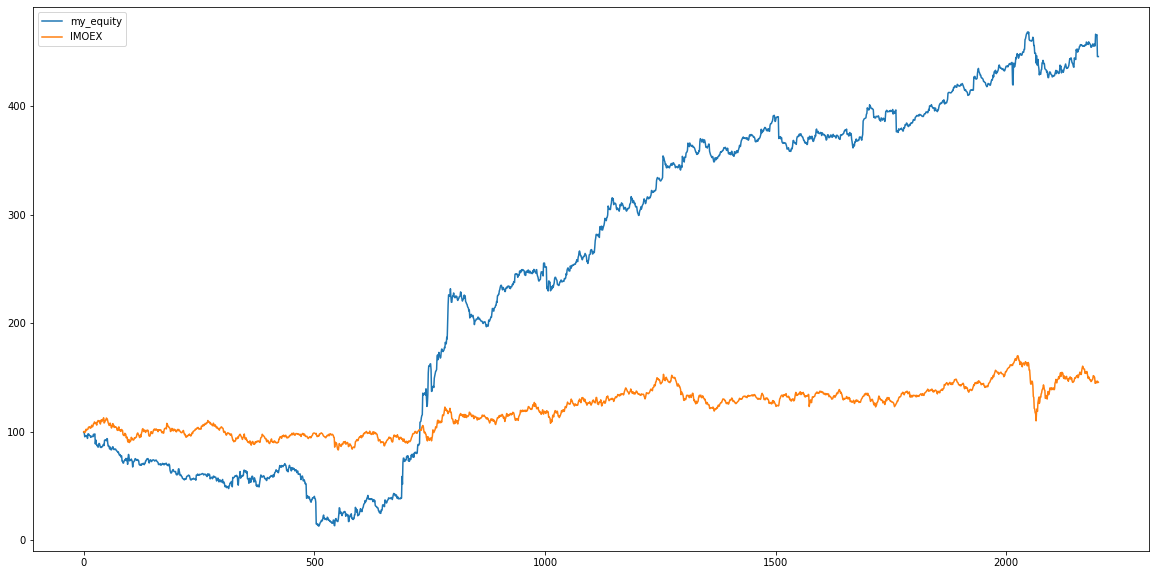

In [105]:
plt.figure(figsize=(20, 10))
plt.plot(for_plot['equity'], label='my_equity')
plt.plot(for_plot['<CLOSE>']/33.18, label='IMOEX')
plt.legend()
plt.show()

In [ ]:
# Большую просадку после первых 500 дней торговли можно обьяснить тем что модель на этот момент оубчалась на небольших наборах данных. А дальше, 
# когда данных для прогноза становилось больше, результаты от использования модели улучшились и превзошли пассивную стратегию "купи и держи"